# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [145]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and see its columns.

In [146]:
from cesnet_datazoo.config import DatasetConfig, AppSelection

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    random_state=42,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)
data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Get only the columns that are needed for clustering.

In [147]:
import numpy as np

features_array = data_df[["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION"]].to_numpy()
correct_clusters_array = data_df[["APP"]].to_numpy().reshape(-1)

## Analysis

Discover statistics of the dataset.

In [148]:
data_df[["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION"]].describe()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION
count,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,56.008869,158.103989,2.914287e+04,1.765262e+05,9.472006
std,2063.250000,2532.477295,2.526515e+06,3.131790e+06,29.747881
min,1.000000,1.000000,1.228000e+03,7.500000e+01,0.000245
25%,8.000000,9.000000,2.723000e+03,3.231000e+03,0.095063
50%,12.000000,13.000000,4.175000e+03,5.261000e+03,0.220863
75%,22.000000,24.000000,7.142000e+03,1.057500e+04,5.029546
max,542482.000000,613033.000000,6.843229e+08,7.610185e+08,356.115967


See the head of the dataset.

In [149]:
data_df[["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION", "APP"]].head()

,PACKETS,PACKETS_REV,BYTES,BYTES_REV,DURATION,APP
0,7.0,7.0,3348.0,2629.0,0.077457,46
1,19.0,16.0,11497.0,5455.0,11.037943,55
2,15.0,15.0,2960.0,3294.0,20.286648,59
3,9.0,9.0,2344.0,2908.0,0.152990,59
4,14.0,16.0,4730.0,6096.0,0.391677,60


## Categorization of original classes

In [150]:
categories_enum = {category: i for i, category in dataset._tables_cat_enum.items()}
app_to_categories = dataset.class_info.categories_mapping
app_enum = {i: app for i, app in dataset._tables_app_enum.items()}
app_to_categories.update({
    "bongacams": "Streaming media",
    "gothbb": "E-commerce",
    "vkontakte": "Social",
    "poe-ninja": "Games",
    "unpkg": "Streaming media",
    "easylist": "Other services and APIs",
    "default-background": "default",
    "uber": "Other services and APIs",
})

correct_categories_array = np.array([categories_enum[app_to_categories[app_enum[app]]] for app in correct_clusters_array])

In [151]:
correct_clusters_array = correct_categories_array

## Preprocessing

Define a pipeline for preprocessing.

In [152]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Clustering

Define function for DBSCAN clustering.

In [153]:
from sklearn.cluster import DBSCAN, HDBSCAN

def dbscan_clustering(data, eps=0.1, min_samples=5):
    return DBSCAN(eps=eps, min_samples=min_samples).fit(data)

def hdbscan_clustering(data, min_cluster_size=5, min_samples=5):
    return HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit(data)

Perform DBSCAN clustering.

In [154]:
model = hdbscan_clustering(preprocessed_array, 400)
labels = model.labels_[:]

## Postprocessing

Remove outliers.

In [155]:
import numpy as np

outliers = np.where(model.labels_ == -1)
# no_outliers_array = np.delete(preprocessed_array, outliers, axis=0)
# no_outliers_clusters_app = np.delete(correct_clusters_array, outliers)
# no_outliers_labels = np.delete(model.labels_, outliers)

print(f"Number of outliers: {len(outliers[0])}")

Number of outliers: 66335


## Evaluation

### Homogeneity, completeness and V-measure

In [156]:
from sklearn.metrics import homogeneity_completeness_v_measure

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(correct_clusters_array, labels)
f"Homogeneity (each cluster contains only members of a single class): {homogeneity}", f"Completeness (all members of a given class are assigned to the same cluster): {completeness}", f"V-measure: {v_measure}"

('Homogeneity (each cluster contains only members of a single class): 0.07895366124492086',
 'Completeness (all members of a given class are assigned to the same cluster): 0.08600552371757963',
 'V-measure: 0.08232886197071639')

### Fowlkes-Mallows index

In [157]:
from sklearn.metrics import fowlkes_mallows_score

"FM index:", fowlkes_mallows_score(labels, correct_clusters_array)

('FM index:', 0.2761832658674544)

### Pair matrix

In [163]:
from sklearn.metrics import pair_confusion_matrix

matrix = pair_confusion_matrix(correct_clusters_array, labels)
f"In true labelling: together, but in predicted: not  {matrix[1, 0]}", f"In true labelling: not together, but in predicted: together  {matrix[0, 1]}", f"In true labelling: together, and in predicted: together  {matrix[1, 1]}", f"In true labelling: not together, and in predicted: not together  {matrix[0, 0]}"

('In true labelling: together, but in predicted: not  1046904516',
 'In true labelling: not together, but in predicted: together  3652527866',
 'In true labelling: together, and in predicted: together  788508630',
 'In true labelling: not together, and in predicted: not together  4511958988')

## Visualization

Define function for visualization.

In [159]:
import matplotlib.pyplot as plt

def plot_clusters(data, label, axis=True):
    plt.figure(figsize=(10, 10))
    plt.scatter(data[:, 0], data[:, 1], c=label)
    
    plt.axis(axis)

    plt.show()

Visualize the clusters.

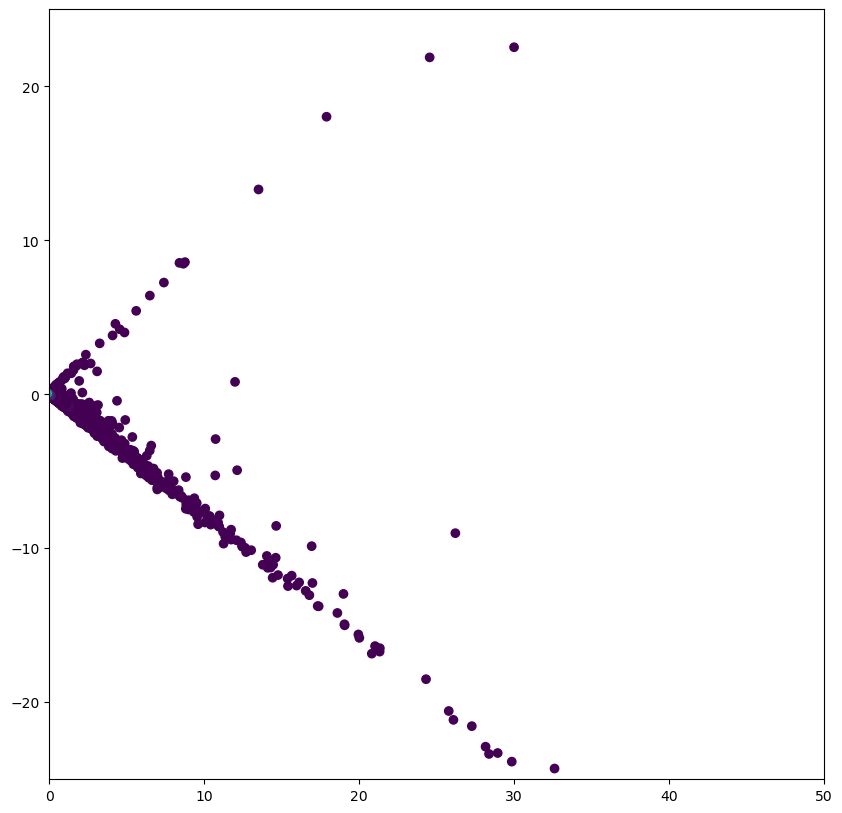

In [164]:
plot_clusters(preprocessed_array, labels, [0, 50, -25, 25])
# plot_clusters(no_outliers_array, no_outliers_labels, [-0.1, 0.2, -0.1, 0.1])

In [165]:
max(labels)

37

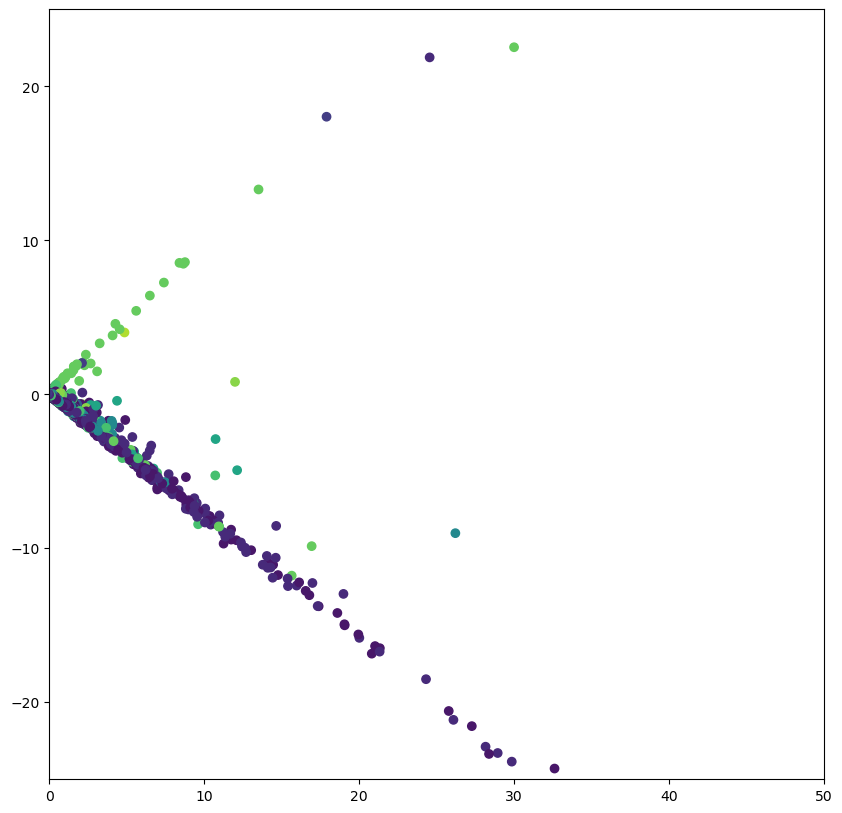

In [166]:
plot_clusters(preprocessed_array, correct_clusters_array, [0, 50, -25, 25])
# plot_clusters(no_outliers_array, no_outliers_clusters_app, [-0.1, 0.2, -0.1, 0.1])